# GradCAM - Gradient Class Activation Map

In [44]:
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-i2h1gadm
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-i2h1gadm
  Resolved https://github.com/albumentations-team/albumentations to commit 82818a0c4a80924d9f903a656c7f549ec6ca9cb2
  Preparing metadata (setup.py) ... done


# Imports

In [45]:
import sys
sys.path.append('/content/GradCAM-Dataset')

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms as T

from tqdm import tqdm
import albumentations as A
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import utils

# Configurations

In [47]:
CSV_FILE = "/content/GradCAM-Dataset/train.csv"
DATA_DIR = "/content/GradCAM-Dataset/"

device = 'cuda'
lr = 0.001
batch = 16
epochs = 30

In [48]:
data = pd.read_csv(CSV_FILE)
data.head()

,img_path,label
0,train_images/mushroom_51.jpg,2
1,train_images/eggplant_37.jpg,1
2,train_images/mushroom_20.jpg,2
3,train_images/eggplant_51.jpg,1
4,train_images/eggplant_26.jpg,1


In [49]:
"""
  cucumber = 0
  eggplant = 1
  mushroom = 2

"""
train_df, valid_df = train_test_split(data, test_size=0.2, random_state=69)

# Augmentations

In [50]:
train_augs = A.Compose(
    [
        A.Rotate(),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

valid_augs = A.Compose(
    [
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

# Load Image Dataset

In [51]:
trainset = utils.ImageDataset(train_df, augs = train_augs, data_dir=DATA_DIR)
validset = utils.ImageDataset(valid_df, augs = valid_augs, data_dir=DATA_DIR)

Text(0.5, 1.0, 'cucumber')

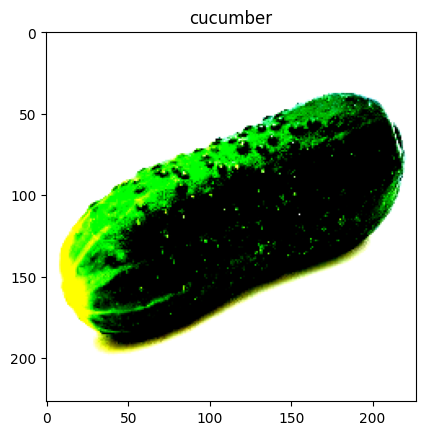

In [52]:
image, label = validset[20]
class_list = ['cucumber', 'eggplant', 'mushroom']
plt.imshow(image.permute(1, 2, 0))
plt.title(class_list[label])



In [53]:
print(f"No. of examples in the {len(trainset)}")
print(f"No. of examples in the {len(validset)}")

No. of examples in the 148
No. of examples in the 38


# Load Dataset into Batches

In [54]:
trainloader = DataLoader(trainset, batch_size=batch, shuffle=True)
validloader = DataLoader(validset, batch_size=batch)

In [55]:
for batch in trainloader:
    inputs, labels = batch
    print(inputs.shape, labels.shape)
print("\n")
for batch in validloader:
    inputs, labels = batch
    print(inputs.shape, labels.shape)


torch.Size([16, 3, 227, 227]) torch.Size([16])
torch.Size([16, 3, 227, 227]) torch.Size([16])
torch.Size([16, 3, 227, 227]) torch.Size([16])
torch.Size([16, 3, 227, 227]) torch.Size([16])
torch.Size([16, 3, 227, 227]) torch.Size([16])
torch.Size([16, 3, 227, 227]) torch.Size([16])
torch.Size([16, 3, 227, 227]) torch.Size([16])
torch.Size([16, 3, 227, 227]) torch.Size([16])
torch.Size([16, 3, 227, 227]) torch.Size([16])
torch.Size([4, 3, 227, 227]) torch.Size([4])


torch.Size([16, 3, 227, 227]) torch.Size([16])
torch.Size([16, 3, 227, 227]) torch.Size([16])
torch.Size([6, 3, 227, 227]) torch.Size([6])


In [56]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 10
No. of batches in validloader : 3


# Create Model

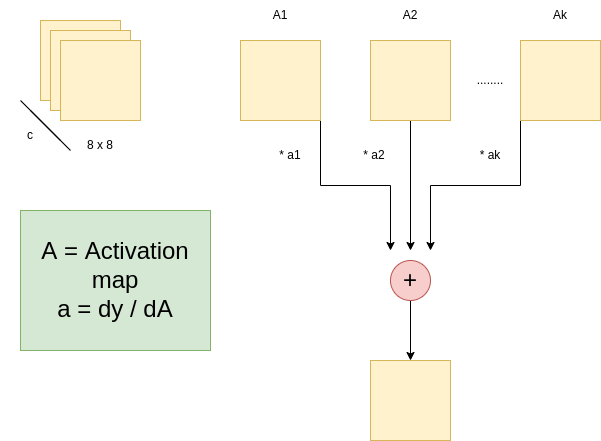

In [57]:
import torch.nn as nn
class ImageModel(nn.Module):

  def __init__(self):
    super(ImageModel, self).__init__()

    self.feature_extractor = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = (5, 5), padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (4, 4), stride = 2),

        nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (5, 5), padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (4, 4), stride = 2),

        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (5, 5), padding  = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (4, 4), stride = 2),

        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (5, 5), padding = 1),
        nn.ReLU(),

    )
    self.maxpool = nn.MaxPool2d(kernel_size = (4, 4), stride = 2)

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(6400, 2048),
        nn.ReLU(),
        nn.Linear(2048, 3)
    )

    self.gradient = None

  def activations_hook(self, grad):
    self.gradient = grad

  def forward(self, images):

    x = self.feature_extractor(images)
    h = x.register_hook(self.activations_hook)
    x = self.maxpool(x)
    x = self.classifier(x)

    return x

  def get_activation_gradients(self): #a1, a2, a3, .... , ak
    return self.gradient

  def get_activations(self, x): #A1, A2, A3, .... , AK
    return self.feature_extractor(x) #64*8*8

In [58]:
model = ImageModel()
model.to(device)

ImageModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6400, out_features=2048, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=3, bias=True)
  )
)

# Create Train and Eval function

In [59]:
def train_fn(dataloader, model, optimizer, loss_fn):

  model.train()
  total_loss = 0.0
  for images, labels in tqdm(dataloader):
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    logits = model(images)
    loss = loss_fn(logits, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss / len(dataloader)




In [60]:
def eval_fn(dataloader, model, loss_fn):

  model.eval()
  total_loss = 0.0
  for images, labels in tqdm(dataloader):
    images = images.to(device)
    labels = labels.to(device)

    logits = model(images)
    loss = loss_fn(logits, labels)

    total_loss += loss.item()
  return total_loss / len(dataloader)




# Training Loop

In [61]:
import torch
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
loss_fn = torch.nn.CrossEntropyLoss()

In [62]:
best_valid_loss = np.Inf

for i in range(epochs):

  train_loss = train_fn(trainloader, model, optimizer, loss_fn)

  # with torch.no_grad():
  valid_loss = eval_fn(validloader, model, loss_fn)

  if valid_loss <= best_valid_loss:
    torch.save(model.state_dict(), 'best_weights.pt')
    best_valid_loss = valid_loss
    print('Model saved successfully!')

  print(f'EPOCH : {i+1} TRAIN LOSS  ; {train_loss} VALID LOSS : {valid_loss}')

100%|██████████| 3/3 [00:00<00:00, 33.69it/s]


Model saved successfully!
EPOCH : 1 TRAIN LOSS  ; 1.1095765590667725 VALID LOSS : 0.8001660505930582


100%|██████████| 3/3 [00:00<00:00, 33.87it/s]


Model saved successfully!
EPOCH : 2 TRAIN LOSS  ; 0.6672550141811371 VALID LOSS : 0.3293044815460841


100%|██████████| 3/3 [00:00<00:00, 32.86it/s]


Model saved successfully!
EPOCH : 3 TRAIN LOSS  ; 0.3283257192000747 VALID LOSS : 0.15643081068992615


100%|██████████| 3/3 [00:00<00:00, 31.30it/s]


EPOCH : 4 TRAIN LOSS  ; 0.29472959488630296 VALID LOSS : 0.18945548931757608


100%|██████████| 3/3 [00:00<00:00, 28.88it/s]


Model saved successfully!
EPOCH : 5 TRAIN LOSS  ; 0.4432284574606456 VALID LOSS : 0.08996829390525818


100%|██████████| 3/3 [00:00<00:00, 33.34it/s]


EPOCH : 6 TRAIN LOSS  ; 0.34648687914013865 VALID LOSS : 0.11788021648923556


100%|██████████| 3/3 [00:00<00:00, 34.03it/s]


EPOCH : 7 TRAIN LOSS  ; 0.4731369078159332 VALID LOSS : 0.3203987230857213


100%|██████████| 3/3 [00:00<00:00, 33.98it/s]


EPOCH : 8 TRAIN LOSS  ; 0.16810362562537193 VALID LOSS : 0.31329797208309174


100%|██████████| 3/3 [00:00<00:00, 33.81it/s]


EPOCH : 9 TRAIN LOSS  ; 0.11211771294474601 VALID LOSS : 0.22190862086911997


100%|██████████| 3/3 [00:00<00:00, 24.10it/s]


EPOCH : 10 TRAIN LOSS  ; 0.05819811103865504 VALID LOSS : 0.12086987332440913


100%|██████████| 3/3 [00:00<00:00, 23.79it/s]


EPOCH : 11 TRAIN LOSS  ; 0.12205762749363203 VALID LOSS : 0.11908102042677153


100%|██████████| 3/3 [00:00<00:00, 19.18it/s]


EPOCH : 12 TRAIN LOSS  ; 0.1546185790619347 VALID LOSS : 0.4118759696854492


100%|██████████| 3/3 [00:00<00:00, 20.11it/s]


EPOCH : 13 TRAIN LOSS  ; 0.2443977643735707 VALID LOSS : 0.14199984880785146


100%|██████████| 3/3 [00:00<00:00, 16.19it/s]


Model saved successfully!
EPOCH : 14 TRAIN LOSS  ; 0.0936647679307498 VALID LOSS : 0.08770707084719713


100%|██████████| 3/3 [00:00<00:00, 19.41it/s]


EPOCH : 15 TRAIN LOSS  ; 0.09404941259417683 VALID LOSS : 0.14666571716467539


100%|██████████| 3/3 [00:00<00:00, 21.57it/s]


Model saved successfully!
EPOCH : 16 TRAIN LOSS  ; 0.05981104304082692 VALID LOSS : 0.01247780475144585


100%|██████████| 3/3 [00:00<00:00, 20.17it/s]


Model saved successfully!
EPOCH : 17 TRAIN LOSS  ; 0.054278950614036606 VALID LOSS : 0.006936081142763821


100%|██████████| 3/3 [00:00<00:00, 19.48it/s]


EPOCH : 18 TRAIN LOSS  ; 0.07092301150837557 VALID LOSS : 0.07461492761164361


100%|██████████| 3/3 [00:00<00:00,  8.22it/s]


Model saved successfully!
EPOCH : 19 TRAIN LOSS  ; 0.10017235905397684 VALID LOSS : 0.0025291930069215596


100%|██████████| 3/3 [00:00<00:00,  8.99it/s]


EPOCH : 20 TRAIN LOSS  ; 0.19944343094248324 VALID LOSS : 0.11248405098255414


100%|██████████| 3/3 [00:00<00:00, 11.73it/s]


EPOCH : 21 TRAIN LOSS  ; 0.10652568181976677 VALID LOSS : 0.02544324070913717


100%|██████████| 3/3 [00:00<00:00, 18.50it/s]


EPOCH : 22 TRAIN LOSS  ; 0.15375765191856772 VALID LOSS : 0.09592785593122244


100%|██████████| 3/3 [00:00<00:00,  9.80it/s]


EPOCH : 23 TRAIN LOSS  ; 0.08041290729888714 VALID LOSS : 0.0037500823988618017


100%|██████████| 3/3 [00:00<00:00, 12.40it/s]


EPOCH : 24 TRAIN LOSS  ; 0.10667385909473523 VALID LOSS : 0.044359175177911915


100%|██████████| 3/3 [00:00<00:00, 33.13it/s]


EPOCH : 25 TRAIN LOSS  ; 0.04284217939712107 VALID LOSS : 0.02333052410782936


100%|██████████| 3/3 [00:00<00:00, 33.55it/s]


EPOCH : 26 TRAIN LOSS  ; 0.03872507144405972 VALID LOSS : 0.009043334401212633


100%|██████████| 3/3 [00:00<00:00, 30.74it/s]


EPOCH : 27 TRAIN LOSS  ; 0.04059620237239869 VALID LOSS : 0.016951561278498655


100%|██████████| 3/3 [00:00<00:00, 32.19it/s]


EPOCH : 28 TRAIN LOSS  ; 0.008398088148715033 VALID LOSS : 0.05942532554399804


100%|██████████| 3/3 [00:00<00:00, 33.33it/s]


EPOCH : 29 TRAIN LOSS  ; 0.04320872519238037 VALID LOSS : 0.002925638715017461


100%|██████████| 3/3 [00:00<00:00, 28.21it/s]


Model saved successfully!
EPOCH : 30 TRAIN LOSS  ; 0.0345291618083138 VALID LOSS : 0.002469801738394987


# Get GradCAM

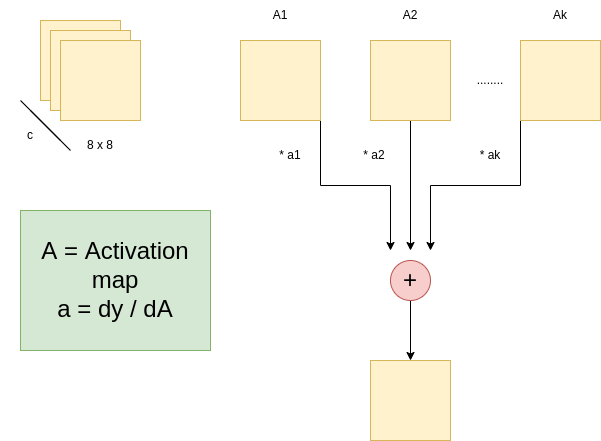

In [63]:
def get_gradcam(model, image, label, size):

  label.backward()
  gradients = model.get_activation_gradients()
  pooled_gradients = torch.mean(gradients, dim= [0, 2, 3]) #a1,a2,...,ak
  activations = model.get_activations(image).detach() #A1,A2,...,AK

  for i in range(activations.shape[1]):
    activations[:, 1, :, :] *= pooled_gradients[1]

  heatmap = torch.mean(activations, dim = 1).squeeze().cpu()
  heatmap = nn.ReLU()(heatmap)
  heatmap /= torch.max(heatmap)
  heatmap = cv2.resize(heatmap.numpy(),(size, size))

  return heatmap

class_list = ['cucumber', 'eggplant', 'mushroom']


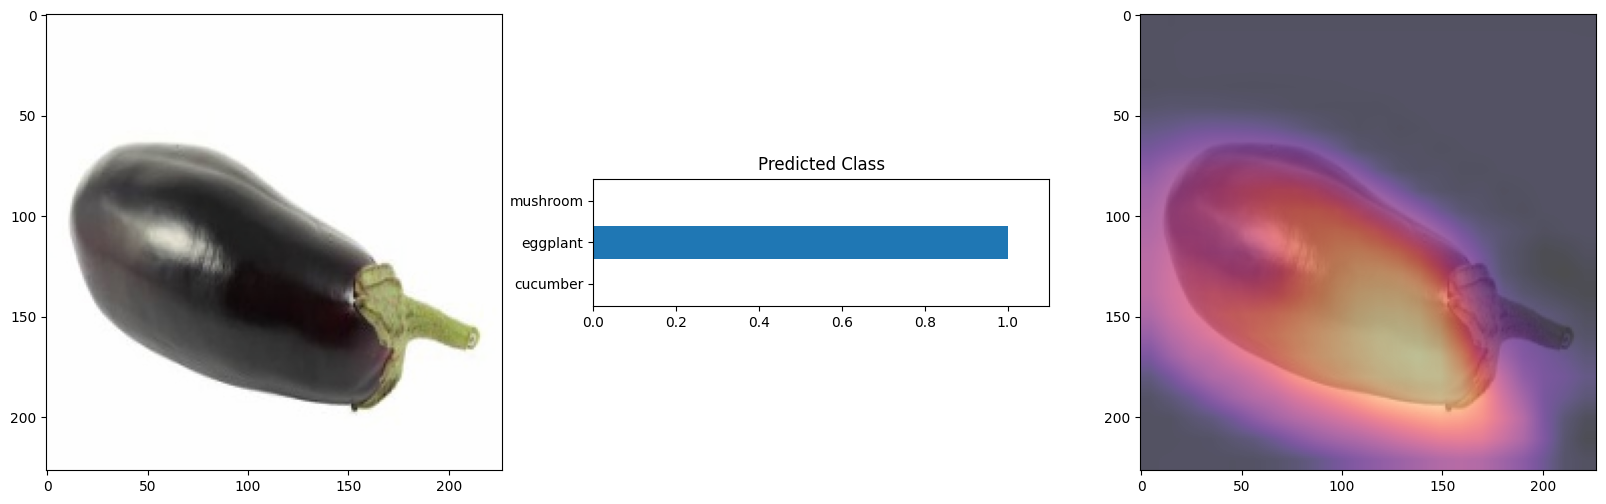

In [64]:
image, label = validset[36]
denorm_image = image.permute(1, 2, 0)*np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
image = image.unsqueeze(0).to(device)
pred = model(image)
heatmap = get_gradcam(model, image, pred[0][2], size = 227)
utils.plot_heatmap(denorm_image, pred, heatmap)

This maps the end of notebook, hehe 😛